In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [5]:
from statsmodels.tsa.arima_model import ARIMA

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [143]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
trading_portfolio = pd.ExcelFile('trading_portfolio.xlsx')
trading_portfolio #load the Excel file with data from all the sheets

In [8]:
trading_portfolio.sheet_names # output of this is a list of all the sheets within the Excel file
# therefore, you can loop through the sheet names and load them into dataframes individually

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

## Read one company stock info into a dataframe

In [73]:
# read one of the excel file sheets into a dataframe
df = pd.read_excel('trading_portfolio.xlsx', sheet_name = trading_portfolio.sheet_names[1])

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      316 non-null    object 
 1   Price     316 non-null    object 
 2   Open      316 non-null    object 
 3   High      316 non-null    object 
 4   Low       316 non-null    object 
 5   Vol.      315 non-null    object 
 6   Change %  315 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.4+ KB


## Data cleaning

In [76]:
df = df[:-1].copy() #drop the last row by slicing and create a deep copy so that subsequent changes will not throw the warning
# 'A value is trying to be set on a copy of a slice from a DataFrame...'

In [77]:
# convert date from string object to datetime format

df['Date'] = pd.to_datetime(df['Date'])

In [78]:
# several of the columns are string objects. Convert to numeric
df[['Price','Open', 'High', 'Low', 'Change %']] = df[['Price','Open', 'High', 'Low', 'Change %']].apply(pd.to_numeric)

In [79]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
310,2020-01-08,19.94,19.89,19.95,19.66,2.79M,0.0005
311,2020-01-07,19.93,20.22,20.28,19.92,2.89M,-0.0075
312,2020-01-06,20.08,20.34,20.34,19.97,1.94M,-0.0108
313,2020-01-03,20.30,20.30,20.44,19.97,3.31M,-0.0039
314,2020-01-02,20.38,20.42,20.44,20.24,2.53M,0.0030


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      315 non-null    datetime64[ns]
 1   Price     315 non-null    float64       
 2   Open      315 non-null    float64       
 3   High      315 non-null    float64       
 4   Low       315 non-null    float64       
 5   Vol.      315 non-null    object        
 6   Change %  315 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.4+ KB


In [81]:
import seaborn as sns

## Plot the stock price vs the date in 2020 and 2021

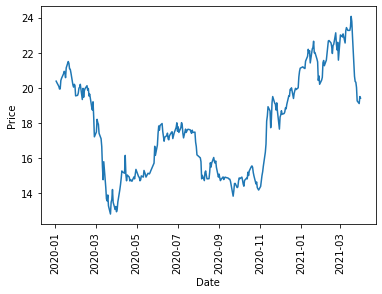

In [82]:
# plot the 'Price' column
sns.lineplot(x = df['Date'], y = df['Price'])
plt.xticks(rotation= 90)
plt.show()

# 1) Predicting daily stock prices

## Create training and testing data from closing stock prices
## All prices from 2020 - > Training
## All prices from 2021 -> testing

In [99]:
# for the dataset, we will use all Q1 - Q4 data from 2020 for training and Q1 data from 2021 as testing
# select 2021 Q1 data as follows
# select just the Price column and convert values to a list form
X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)
X_test

[19.41,
 19.5,
 19.1,
 19.25,
 20.02,
 20.32,
 20.36,
 20.66,
 22.94,
 23.78,
 24.08,
 23.48,
 23.28,
 23.28,
 23.36,
 23.44,
 23.26,
 22.56,
 23.08,
 22.9,
 22.98,
 22.98,
 23.02,
 21.58,
 22.6,
 22.16,
 22.48,
 23.14,
 22.48,
 22.42,
 21.96,
 22.34,
 22.56,
 22.7,
 22.68,
 22.3,
 21.94,
 21.58,
 21.26,
 21.56,
 21.44,
 20.6,
 20.44,
 20.2,
 20.68,
 20.42,
 21.48,
 21.64,
 22.02,
 22.0,
 22.66,
 22.3,
 22.22,
 21.42,
 22.12,
 22.0,
 22.2,
 21.8,
 21.52,
 21.1,
 21.14,
 21.14,
 21.2]

In [101]:
# likewise, selecte all data from 2020 for training the model
X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
X_train

[21.12,
 20.94,
 20.62,
 20.0,
 19.9,
 19.97,
 19.84,
 19.68,
 19.39,
 20.0,
 19.89,
 19.91,
 19.52,
 19.54,
 19.05,
 18.8,
 18.85,
 18.62,
 18.53,
 18.49,
 18.69,
 18.45,
 18.33,
 17.64,
 18.68,
 19.14,
 18.73,
 19.06,
 19.12,
 19.5,
 19.15,
 18.2,
 17.72,
 18.68,
 18.92,
 18.39,
 18.1,
 16.79,
 16.32,
 15.52,
 15.2,
 14.99,
 14.7,
 14.37,
 14.16,
 14.3,
 14.62,
 14.51,
 14.97,
 15.16,
 15.46,
 15.54,
 15.49,
 15.25,
 14.99,
 15.18,
 14.8,
 14.84,
 14.71,
 14.38,
 14.5,
 14.72,
 14.9,
 14.81,
 14.85,
 14.67,
 14.34,
 14.3,
 14.54,
 14.53,
 14.12,
 13.81,
 14.0,
 14.66,
 14.78,
 14.78,
 14.83,
 14.85,
 14.88,
 14.9,
 14.84,
 14.76,
 14.91,
 14.77,
 14.7,
 14.86,
 15.07,
 14.9,
 15.46,
 15.82,
 15.7,
 15.8,
 16.02,
 15.7,
 15.47,
 15.72,
 15.19,
 14.81,
 14.8,
 15.0,
 15.25,
 15.17,
 14.7,
 15.0,
 14.8,
 15.78,
 16.0,
 16.17,
 16.65,
 16.9,
 17.47,
 17.45,
 17.58,
 17.4,
 17.47,
 17.6,
 17.63,
 17.62,
 17.45,
 17.64,
 17.14,
 17.4,
 17.89,
 18.01,
 17.72,
 17.45,
 17.77,
 17.52,
 18.0,


In [102]:
len(X_train), len(X_test)

(252, 63)

## Establish and ARIMA model

In [110]:
from statsmodels.tsa.arima.model import ARIMA 

In [140]:
# specify incremental training samples

# Prepare the ARIMA model for training

model_predictions = []
num_test_obser = len(X_test)

for i in range(num_test_obser):
    model = ARIMA(X_train, order = (10, 1, 1)) # where p = 10 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make the tren stationary
                                              # q = 1 which is the size of the moving average window
    model_fit =  model.fit()
    output = model_fit.forecast()
    
    model_predictions.append (output[0]) # append the predicted value to the model_predictions list
    
    true_test_value = X_test[i] # the corresponding test value of the X_test list
    X_train.append(true_test_value) # update the training dataset by appending the true_test_value. This will be used in the next training round
    
    

In [136]:
len(model_predictions)

63

In [130]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  441
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -297.387
Date:                Sun, 24 Jul 2022   AIC                            606.775
Time:                        22:37:02   BIC                            631.295
Sample:                             0   HQIC                           616.448
                                - 441                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2673      0.520      0.514      0.607      -0.752       1.286
ar.L2          0.0718      0.058      1.233      0.217      -0.042       0.186
ar.L3         -0.0802      0.067     -1.189      0.2

<AxesSubplot:xlabel='Date'>

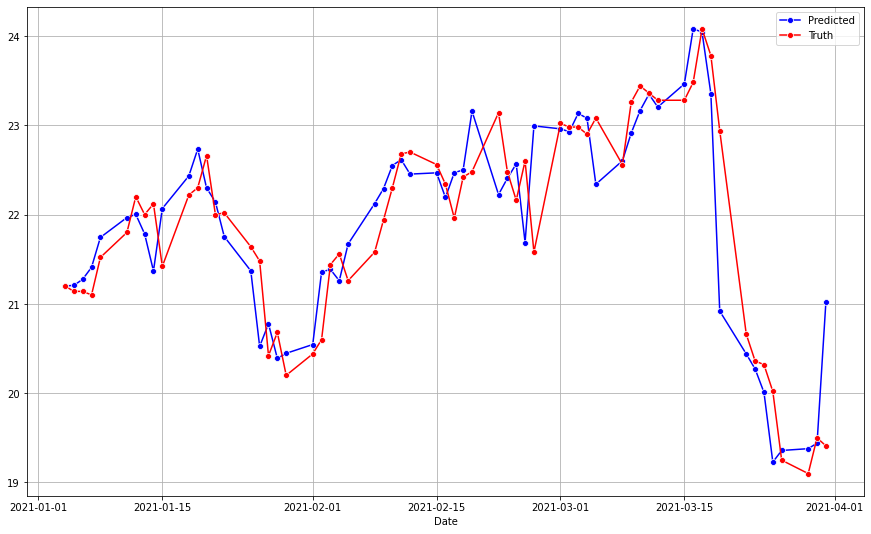

In [142]:
# plot the predicted and actual values for daily stock prices.

plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range, y=model_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')
# the Predicted values are shifted to the left by 1 day - intersting!

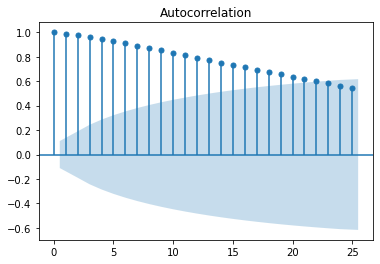

In [145]:
#Autocorrelation plot for stock prices.
plot_acf(df['Price']);

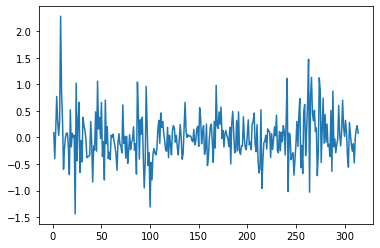

In [152]:
# Plot return values (today's stock price minus yesterday's stock price)
plt.plot(df['Price'].diff().dropna()) #stationatity of the stock price after 1 order of differencing is pretty good. 
# this differencing is essentially the daily returns of the closing price of the stock
# We will therefore start by using d = 1

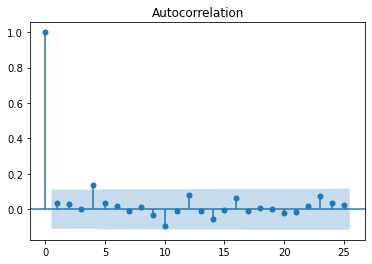

In [148]:
# Plot autocorrelation for the above return values
plot_acf(df['Price'].diff().dropna()); 
# With the autocorrelation plot, only significant correlation was at the 4th value
# we will start with using q = 4

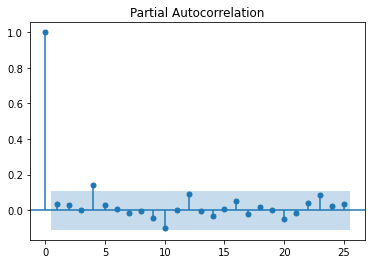

In [154]:
# Plot partial autocorrelation for the return values (today's stock price minus yesterday's stock price)
plot_pacf(df['Price'].diff().dropna()); #similarly with the partial autocorrelation plot
# we can see that the starting point of p = 4

In [166]:
# Prepare the ARIMA model again for training but using different p, d and q values

model_predictions = []
num_test_obser = len(X_test)

for i in range(num_test_obser):
    model = ARIMA(X_train, order = (3, 1, 1)) # where p = 10 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make the tren stationary
                                              # q = 0 which is the size of the moving average window
    model_fit =  model.fit()
    output = model_fit.forecast()
    
    model_predictions.append (output[0]) # append the predicted value to the model_predictions list
    
    true_test_value = X_test[i] # the corresponding test value of the X_test list
    X_train.append(true_test_value) # update the training dataset by appending the true_test_value. 
                                    # This will be used in the next training round
    

In [167]:
print(model_fit.summary())#model summary

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  960
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -784.118
Date:                Wed, 27 Jul 2022   AIC                           1578.236
Time:                        21:02:27   BIC                           1602.565
Sample:                             0   HQIC                          1587.501
                                - 960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7611      0.112     -6.822      0.000      -0.980      -0.542
ar.L2          0.1159      0.058      1.989      0.047       0.002       0.230
ar.L3          0.0203      0.063      0.322      0.7

<AxesSubplot:xlabel='Date'>

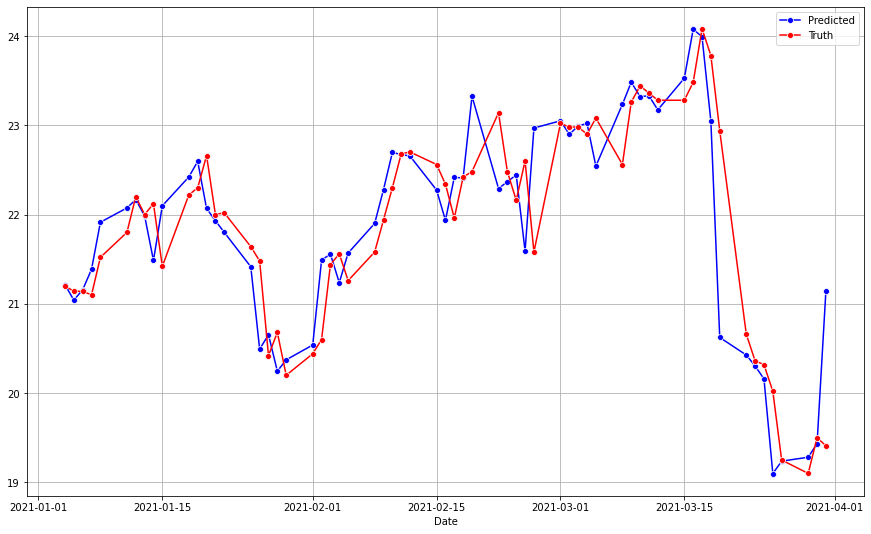

In [193]:
# plot the predicted and truth values

plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range, y=model_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')
#there is an offset of one day between Predicted and Truth values

In [188]:
from datetime import datetime
from datetime import timedelta

<AxesSubplot:xlabel='Date'>

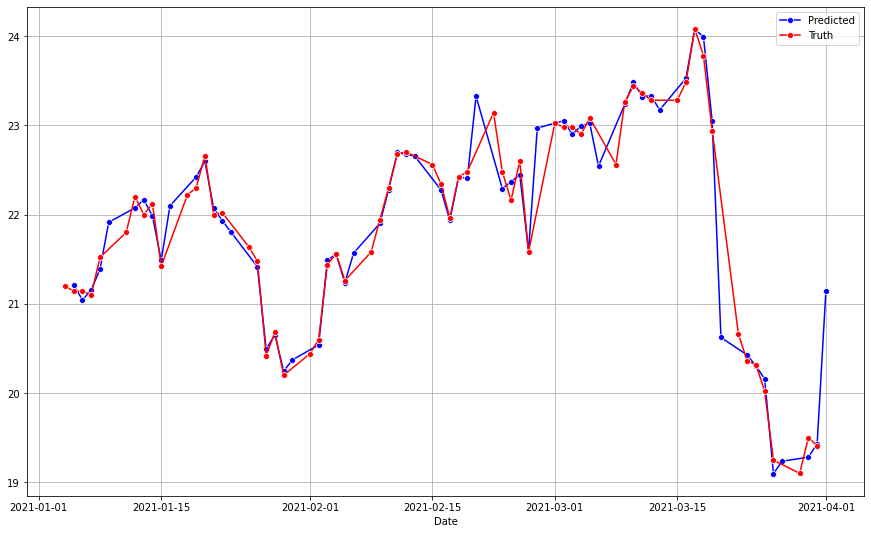

In [198]:
# The offset in the plot can be corrected by adding one day to the Predicted value X labels

plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range+timedelta(days=1), y=model_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')

# Predicting average monthly stock prices

In [336]:
# extract monthly average stock prices and save in train or test lists

month_train = []
month_test = []

for i in range (1,13):
    month_train.append(df[(pd.DatetimeIndex(df['Date']).year == 2020) & (pd.DatetimeIndex(df['Date']).month == i)]['Price'].mean())
    month_test.append(df[(pd.DatetimeIndex(df['Date']).year == 2021) & (pd.DatetimeIndex(df['Date']).month == i)]['Price'].mean())
    
#remove null values from a list if a month is missing (especially true for months in an incomplete year e.g. 2021)
month_train = [x for x in month_train if str(x) !='nan']
month_test = [x for x in month_test if str(x) != 'nan']


In [381]:
# run an ARIMA model for predicting the monthly average stock price 

month_predictions = []
month_test_obser = len(month_test)

for i in range(month_test_obser):
    model_month = ARIMA(month_train, order = (2, 1, 2)) # where p = 10 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make the tren stationary
                                              # q = 0 which is the size of the moving average window
    model_month_fit =  model_month.fit()
    output_month = model_month_fit.forecast()
    
    month_predictions.append (output_month[0]) # append the predicted value to the model_predictions list
    
    month_test_value = month_test[i] # the corresponding test value of the month_test list
    month_train.append(month_test_value) # update the training dataset by appending the true_test_value. 
                                    # This will be used in the next training round

In [382]:
print(model_month_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -43.766
Date:                Thu, 28 Jul 2022   AIC                             97.533
Time:                        22:49:03   BIC                            104.703
Sample:                             0   HQIC                            99.870
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7553      0.100      7.539      0.000       0.559       0.952
ar.L2         -0.9040      0.054    -16.839      0.000      -1.009      -0.799
ma.L1         -0.2883      0.138     -2.092      0.0

<AxesSubplot:>

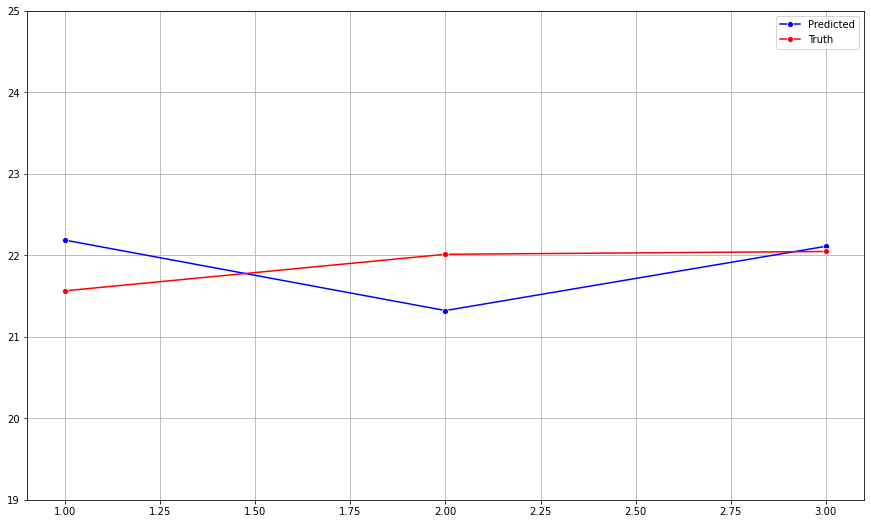

In [391]:
plt.figure(figsize = (15, 9))
plt.grid(True)
plt.ylim(ymin=19, ymax=25)

month_range = [1,2,3]

sns.lineplot(x=month_range, y=month_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=month_range, y=month_test, color = 'red', marker = 'o', label = 'Truth')

# Predicting weekly stock prices

In [357]:
import warnings
warnings.filterwarnings('ignore')
# ignore warnings for the following lines of code for week determination

In [364]:
# extract the weekly stock price averages for training and testing data
week_train = []
week_test = []

for i in range (1,54):
    week_train.append(df[(pd.DatetimeIndex(df['Date']).year == 2020) & (pd.DatetimeIndex(df['Date']).week == i)]['Price'].mean())
    week_test.append(df[(pd.DatetimeIndex(df['Date']).year == 2021) & (pd.DatetimeIndex(df['Date']).week == i)]['Price'].mean())
    
#remove null values from the list if a week is missing (especially true for weeks in an incomplete year, e.g. 2021)
week_train = [x for x in week_train if str(x) !='nan']
week_test = [x for x in week_test if str(x) != 'nan']

In [398]:
# run an ARIMA model for preciting average weekly stock price
week_predictions = []
week_test_obser = len(week_test)

for i in range(week_test_obser):
    model_week = ARIMA(week_train, order = (2, 1, 2)) # where p = 10 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make the tren stationary
                                              # q = 0 which is the size of the moving average window
    model_week_fit =  model_week.fit()
    output_week = model_week_fit.forecast()
    
    week_predictions.append (output_week[0]) # append the predicted value to the model_predictions list
    
    week_test_value = week_test[i] # the corresponding test value of the month_test list
    week_train.append(week_test_value) # update the training dataset by appending the true_test_value. 
                                    # This will be used in the next training round

In [399]:
print(model_week_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   78
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -98.297
Date:                Thu, 28 Jul 2022   AIC                            206.595
Time:                        23:20:16   BIC                            218.314
Sample:                             0   HQIC                           211.282
                                 - 78                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0302      0.153     -0.197      0.844      -0.330       0.270
ar.L2         -0.8393      0.129     -6.484      0.000      -1.093      -0.586
ma.L1          0.2973      0.099      2.997      0.0

<AxesSubplot:>

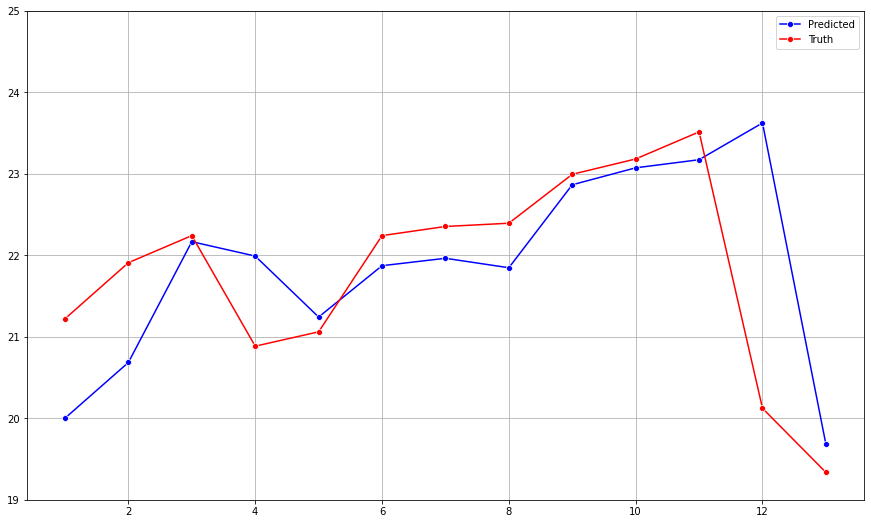

In [400]:
plt.figure(figsize = (15, 9))
plt.grid(True)
plt.ylim(ymin=19, ymax=25)

week_range = [1,2,3,4,5,6,7,8,9,10,11,12,13]

sns.lineplot(x=week_range, y=week_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=week_range, y=week_test, color = 'red', marker = 'o', label = 'Truth')